# Gauge transformation of the gauge links in a LC coordinate lattice

## Step 0

### Writting the fields from files

In [1]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = 'su3'

import curraun.su as su
import numpy as np
import pickle

Using SU(3)
Using Numba
Using double precision


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# We read the fields

fields = np.load('gauge_links_fields_glasma_test.npz')
ux = fields['ux']; aeta = fields['aeta']

with open('parameters_gauge_transf_glasma_test.pickle', 'rb') as f:
    param = pickle.load(f)

In [3]:
print(np.shape(ux))
print(np.shape(aeta))

(64, 16384, 9)
(64, 16384, 9)


In [4]:
# We get the relevant parameters

N = param['N']
Dg = param['DG']
L = param['L']
Qs = param['QS']

t_steps = np.shape(ux)[0]

a = L/N
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))

In [5]:
# We reshape the transverse component into a N*N matrix

ux_r = ux.reshape((t_steps, N, N, Dg))
aeta_r = aeta.reshape((t_steps, N, N, Dg))

print(np.shape(ux_r))
print(np.shape(aeta_r))

(64, 128, 128, 9)
(64, 128, 128, 9)


## Step 1

### We write the relevant magnitude in LC coordinates

In [25]:
# We construct the z links from Aeta

uz = su.GROUP_TYPE([[[[su.mexp(su.mul_s(aeta_r[t,x,y], 1j*g*a*(z-N//2))) for z in range(N)] for y in range(N)] for x in range(N)] for t in range(t_steps)])

/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 397:
@myjit
def mul_s(g0, f):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/lustre/HQCD/carlos.lamas/curraun/curraun/su3.py:197: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 119:
@myjit
def mul(a, b):
^

  t = mul(t, a)
/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerforma

In [26]:
uz_test = uz.reshape(t_steps, N, N, N, 3, 3)
print(uz_test[t_steps//2, N//2, N//2, 0, :, :])

[[ 13.89927604+6.22154970e-15j   4.32828135+8.52270231e+00j
   -9.24560958-2.14675070e+01j]
 [  4.32828135-8.52270231e+00j   7.49830605-9.18208511e-15j
  -16.02494962-1.46596648e+00j]
 [ -9.24560958+2.14675070e+01j -16.02494962+1.46596648e+00j
   39.6040058 +1.61717580e-14j]]


In [27]:
# We define a function that, given a set of gauge links, returns the values over the x^+ axis

def get_LC_links (u_x):
    uminus = su.GROUP_TYPE([[[[su.mul(uz[t,x,y,z],u_x[t,x,y]) for z in range(N)] for y in range(N)] for x in range(N)] for t in range(t_steps)])
    uplus = su.GROUP_TYPE([[[[su.mul(uz[t,x,y,z],su.GROUP_TYPE(su.dagger(u_x[t,x,y]))) for z in range(N)] for y in range(N)] for x in range(N)] for t in range(t_steps)])
    return uplus, uminus

In [28]:
u_plus_temp, u_minus_temp = get_LC_links(ux_r)

print(np.shape(u_plus_temp))
print(np.shape(u_minus_temp))

(64, 128, 128, 128, 9)
(64, 128, 128, 128, 9)


In [29]:
print(u_plus_temp[t_steps//2, N//2, N//2, N//2, :])

[ 0.99766304+0.00598429j -0.05701835+0.03213106j  0.01072109+0.0153036j
  0.05689127+0.032335j    0.99784253-0.00343299j  0.00397506+0.00073196j
 -0.01100067+0.01514778j -0.00384629-0.00046327j  0.99981396-0.00256212j]


## Step 2

### We gauge transform the relevant quantity to LC gauge

In [30]:
# We construct a function that gives the gauge operator at a given point

def gauge_operator(u, x):
    v = su.GROUP_TYPE([[su.unit() for z in range(N)] for y in range(N)])
    for t in range(x//2):
        buffer = v
        v = su.GROUP_TYPE([[su.mul(u[t,x-t,y,z], buffer[y,z]) for z in range(N)] for y in range(N)])
    return v

In [31]:
# We construct an array with the gauge operator over the x^+ axis

v_LC = su.GROUP_TYPE(np.zeros((t_steps, N, N, Dg)))
for x in range (N):
    if x%2 == 0:
        v_LC[x//2,:,:,:] = gauge_operator(u_minus_temp, x)

print(np.shape(v_LC))

/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 440:
@myjit
def unit():
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


(64, 128, 128, 9)


In [32]:
# We construct a function that performs the gauge transformation of the plus link

def act_plus_link (u,v):
    buffer1 = su.GROUP_TYPE([[[su.mul(su.GROUP_TYPE(su.dagger(v[t+1, y, z])), u[t, t, y,z]) for z in range(N)] for y in range(N)] for t in range(t_steps-1)])
    r = su.GROUP_TYPE([[[su.mul(buffer1[t,y,z], v[t,y,z]) for z in range(N)] for y in range(N)] for t in range (t_steps-1)])
    return r

In [33]:
# We transform the plus link

uplus_LC = act_plus_link(u_plus_temp, v_LC)

print(np.shape(uplus_LC))

(63, 128, 128, 9)


In [34]:
# We plot U_+ at one point of the axis to have some intuition about its value

uplus_LC_r = uplus_LC.reshape((t_steps-1, N, N, 3, 3))
print(uplus_LC_r[t_steps//2, N//2, N//2, :])

[[ 0.98675732-0.03360514j -0.1039674 +0.02680459j  0.11679902-0.00331073j]
 [ 0.11605198-0.01505914j  0.95867834-0.21079397j -0.07940447+0.12845949j]
 [-0.10646263-0.01231045j  0.08754094+0.13156985j  0.95056108+0.24489541j]]


Close to the identity but not exactly

## Step 3

### We transform $U_-$ to LC gauge as a check

In [54]:
# We construct a function with the gauge operator at the next x^- step to the x^+ axis

v_LC_plus1 = su.GROUP_TYPE([[[su.mul(u_minus_temp[t+1,t-1,y,z], v_LC[t,y,z]) for z in range(N)] for y in range(N)] for t in range(t_steps-1)])

In [59]:
r = su.mul(su.GROUP_TYPE(su.dagger(u_minus_temp[t-1, t+1, y, z])), u_minus_temp[t,t,y,z])
print(r)

((0.9982771502410732-0.049962718501213116j), (0.01840524470039707-0.008504370441913893j), (0.013218412540937858+0.0189909001190809j), (-0.01843508476633659-0.007308717660413846j), (0.999565571199153-0.009566035915441461j), (-0.007064087233639625-0.01827536039466166j), (-0.013679774403311515+0.01913248898138556j), (0.007860120130976122-0.01744422519382576j), (0.997766983024799+0.059512828383093366j))


In [55]:
# We construct a function that performs the gauge transformation of the minus links

def act_minus_links(u, v, aux): #TODO: Writte the function with only u and v as inputs?
    buffer1 = su.GROUP_TYPE([[[su.mul(su.GROUP_TYPE(su.dagger(aux[t, y, z])), u[t, t, y,z]) for z in range(N)] for y in range(N)] for t in range(t_steps-1)])
    r = su.GROUP_TYPE([[[su.mul(buffer1[t,y,z], v[t,y,z]) for z in range(N)] for y in range(N)] for t in range (t_steps-1)])
    return r

In [57]:
# We transform the minus link

uminus_LC = act_minus_links(u_minus_temp, v_LC, v_LC_plus1)

print(np.shape(uminus_LC))

(63, 128, 128, 9)


In [58]:
# We plot U_- at one point of the axis to check that it is close to identity

uminus_LC_r = uminus_LC.reshape((t_steps-1, N, N, 3, 3))
print(uminus_LC_r[t_steps//2, N//2, N//2, :, :])

[[ 0.99919118+0.01113717j -0.02553184+0.00935592j -0.01694606-0.02159581j]
 [ 0.02476677+0.00932946j  0.9992828 -0.00495239j -0.01088555-0.0242987j ]
 [ 0.01754612-0.02201495j  0.0103879 -0.02370733j  0.99924934-0.00618728j]]


The gauge links in minus direction are indeed transformed to the identity. Much closer to 1 that $U_+$ links

# Step 4

### We plot the transformed links

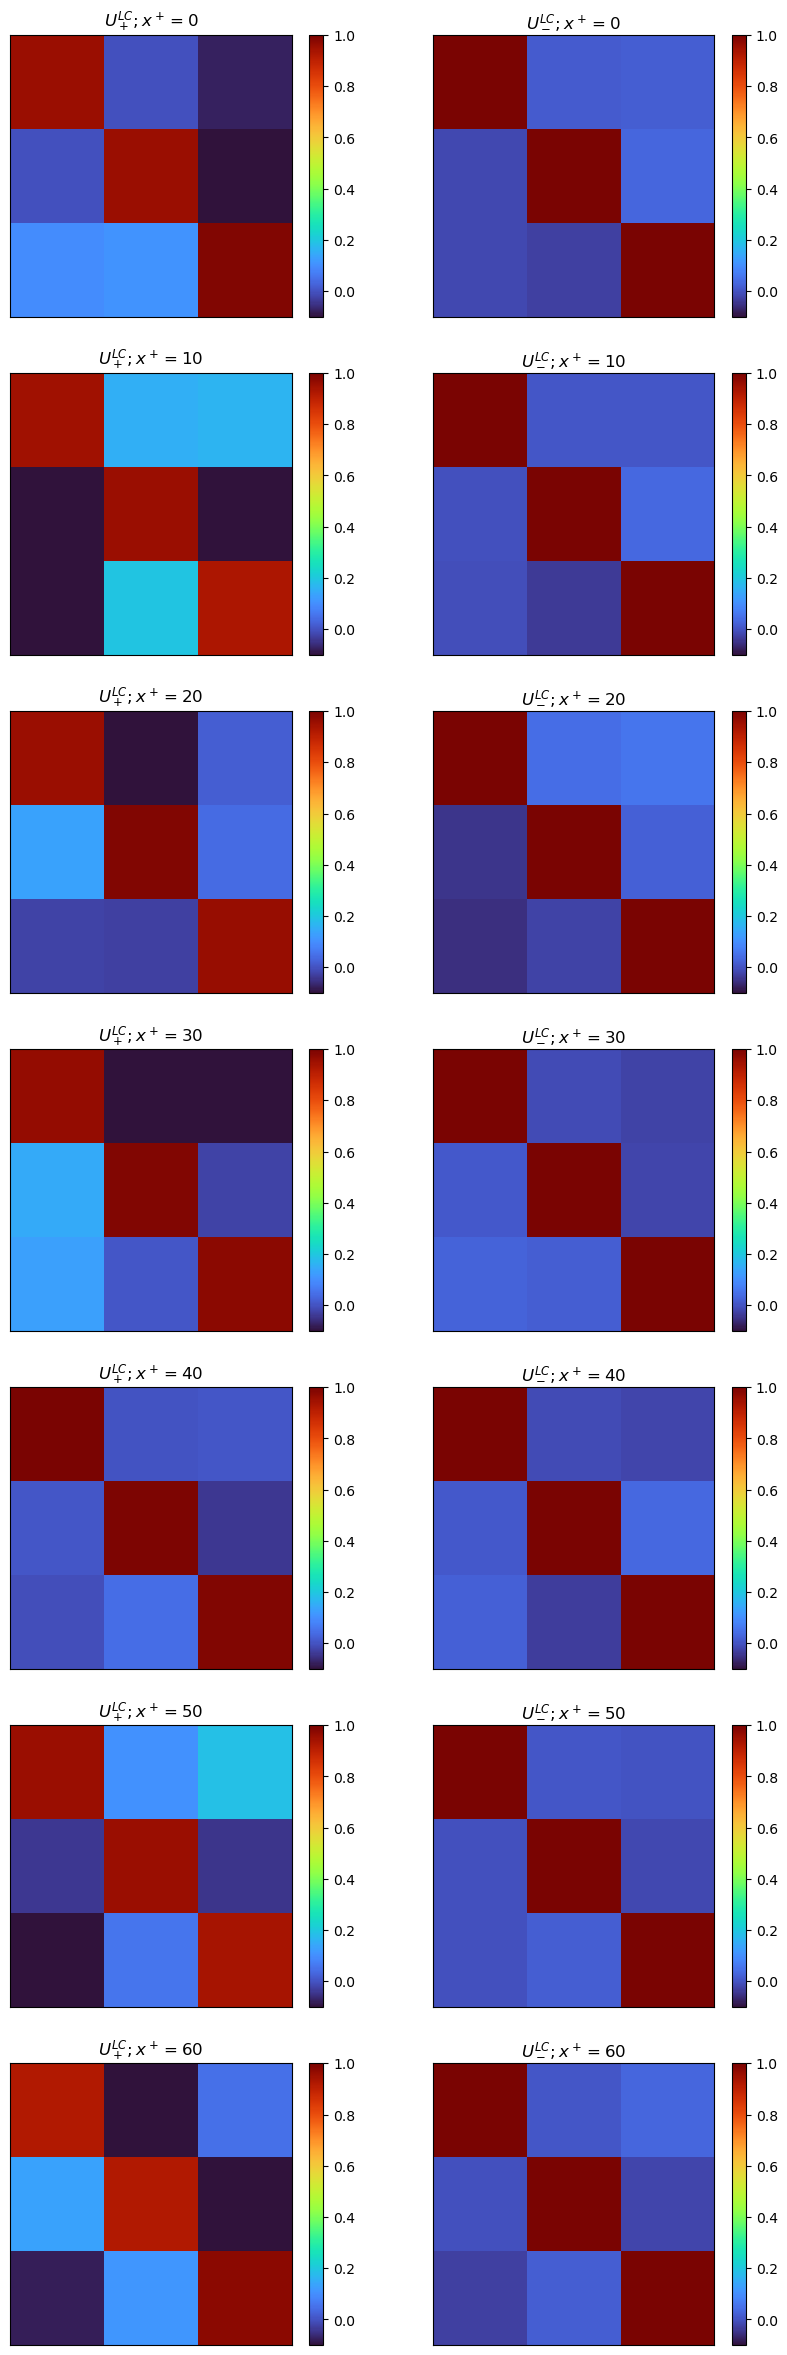

In [53]:
import matplotlib.pyplot as plt 

y = N//2; z = N//2

fig, axs = plt.subplots(t_steps//10 +1, 2, figsize=(10,30))

for t in range(t_steps//10 + 1): 
    tau = 10*t
    plot1 = axs[t,0].imshow(uplus_LC_r[tau, y, z, :, :].real, cmap='turbo', vmin=-0.1, vmax=1) 
    axs[t,0].set_title(r'$U_+^{LC}; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,0])
    axs[t,0].axes.get_xaxis().set_visible(False)
    axs[t,0].axes.get_yaxis().set_visible(False)
    
    plot1 = axs[t, 1].imshow(uminus_LC_r[tau, y, z, :, :].real, cmap='turbo', vmin=-0.1, vmax=1)
    axs[t,1].set_title(r'$U_-^{LC}; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,1])
    axs[t,1].axes.get_xaxis().set_visible(False)
    axs[t,1].axes.get_yaxis().set_visible(False)

In [26]:
for t in range (t_steps//10):

    n = su.tr(np.array(su.mul(u_plus_temp[10*t, N//2, :], su.dagger(uplus_LC[10*t, N//2, :]))) - su.unit())
    d = su.sq(u_plus_temp[10*t, N//2, :] - su.unit())

    r = n/d
    print(r)
# plt.imshow(p.real, cmap='turbo', vmin=-0.1, vmax=1) 


(-0.43545867840567715+0.010681594557779981j)
(-8.253658668429253-0.3721170428229103j)
(-0.6227661635576565+0.010763920515429633j)
(-8.445802461570052+0.0870091056798502j)
(-2.472325082776163+0.02419007299067866j)
(-0.5599836889724112+0.01824553756008831j)


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 387:
@myjit
def tr(a):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
